# Check image sizes and convert data into a torch tensor

(256, 256)


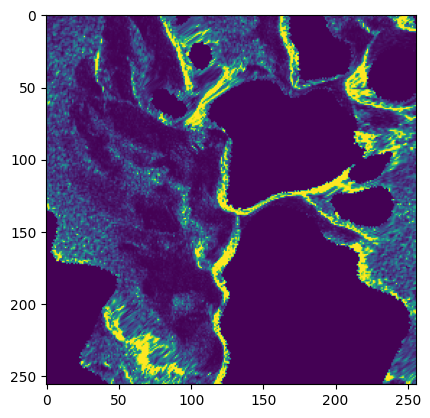

In [2]:
from PIL import Image
import os

# # image size
path_to_image = '/gws/nopw/j04/iecdt/amorgan/data_copy/sar_images/train/Crane_2002-11-18_ERS_20_3_195__93_102_0_0_0.png'
image = Image.open(path_to_image)
print(image.size)

# print some of the values from the matrix itself
#plot this image with the labels
import matplotlib.pyplot as plt
import numpy as np
image = Image.open(path_to_image)
image = np.array(image)
plt.imshow(image)
plt.show()




#all the images are different sizes -BUT 
#this was accounted for in data_preprocessing!!

#now the correct images are stored in these 3 paths

train_data_path = '/gws/nopw/j04/iecdt/amorgan/data_copy/sar_images/train'
val_data_path = '/gws/nopw/j04/iecdt/amorgan/data_copy/sar_images/val'
test_data_path = '/gws/nopw/j04/iecdt/amorgan/data_copy/sar_images/test'


### All the images are 256x256. Amazing! Now to make a torch tensor...

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import torchvision
import os

### I have 46700+ patches that are saved, with 2 labels

###IGNORE: this code gets the original filenames for the full images

In [3]:
# import re #regular expression (or RE) specifies a set of strings that matches it

# processed_dir = "/gws/nopw/j04/iecdt/amorgan/data_copy/sar_images/"

# output_file = "original_square_images.txt"

# original_images = set()

# # Regex pattern to detect patching suffix
# patch_pattern = re.compile(r"__\d+_\d+_\d+_\d+_\d+\.png$")

# # Scan processed directory
# for root, _, files in os.walk(processed_dir):
#     for file in files:
#         if file.endswith(".png"):
#             original_name = patch_pattern.sub(".png", file)  # Remove patching info
#             original_images.add(original_name)

# # Save the list of original images
# with open(output_file, "w") as f:
#     for img in sorted(original_images):
#         f.write(img + "\n")

# print(f"Extracted {len(original_images)} original images. Saved to {output_file}.")


In [4]:
# import re

# processed_dir = "/gws/nopw/j04/iecdt/amorgan/data_copy/sar_images/"

# output_file = "original_square_images_actual_names.txt"

# original_images = set()

# # Regex pattern to detect patching suffix
# patch_pattern = re.compile(r"__\d+_\d+_\d+_\d+_\d+\.png$")

# # Scan processed directory

# for root, _, files in os.walk(processed_dir):
#     for file in files:
#         if file.endswith(".png"):
#             numbers = list(map(int, re.findall(r"\d+", file)))
#             # print(f"numbers in : {file} : {numbers}")
#             if numbers[-3:] == [0, 0, 0]:
#                original_images.add(file)
            


# # Save the list of original images
# with open(output_file, "w") as f:
#     for img in sorted(original_images):
#         f.write(img + "\n")
# print(original_images)
# print(f"Extracted {len(original_images)} original images. Saved to {output_file}.")


In [4]:
class GlacierSegDataset(Dataset):
    """"
   
    Each SAR image has:
    - A corresponding segmentation mask (ice vs. background)
    - A corresponding front mask (glacier front detection)

    Args:
        - mode (str): 'train', 'val', or 'test'
        - parent_dir (str): Root directory containing 'sar_images', 'zones', and 'fronts' folders.
      

    """

    def __init__(self, mode, parent_dir, label_type = "mask"):
        print(f"Initializing GlacierSegDataset in {mode} mode...")
        self.label_type = label_type #choose between 'mask' and 'front'

        self.image_dir = os.path.join(parent_dir, "sar_images", mode)
        self.mask_dir = os.path.join(parent_dir, "zones", mode)
        self.front_dir = os.path.join(parent_dir, "fronts", mode)

        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.fronts = sorted(os.listdir(self.front_dir))


        print(f"Number of images: {len(self.images)}, masks: {len(self.masks)}, fronts: {len(self.fronts)}")
        assert len(self.images) == len(self.masks) == len(self.fronts), "Mismatch in dataset size!"

        self.transform = transforms.Compose([
            transforms.ToTensor(), #converts HxW numpy array to 1xHxW Pytorch tensor
            transforms.Normalize(mean=0.3047126829624176, std=0.32187142968177795) #mean and sd of the data

         ])


    def __len__(self):
        """"
        Returns the number of samples in the dataset
        """
        return len(self.images)
    
    def __getitem__(self, idx):
        """"
        Loads a SAR image,  and its corresponding label (either mask or front)
        """

        image_name = self.images[idx]
        #print(f"Loading image: {image_name}")
        image = cv2.imread(os.path.join(self.image_dir, image_name), cv2.IMREAD_GRAYSCALE)


        # Choose label type dynamically
        if self.label_type == "mask":
            label_path = os.path.join(self.mask_dir, self.masks[idx])
            
        elif self.label_type == "front":
            label_path = os.path.join(self.front_dir, self.fronts[idx])
            
        else:
            raise ValueError("Invalid label_type! Choose 'mask' or 'front'.")
        
            
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        image = self.transform(image)
        label = torchvision.transforms.ToTensor()(label)  # No normalization for label
    # image_path = os.path.join(self.image_dir, self.images[idx])
        # mask_path = os.path.join(self.mask_dir, self.masks[idx])
        # front_path = os.path.join(self.front_dir, self.fronts[idx])

        # image = Image.open(image_path).convert("L")
        # mask = Image.open(mask_path).convert("L")
        # front = Image.open(front_path).convert("L")

        # # Apply transformations
        # image = self.transform(image)
        # mask = self.transform(mask)
        # front = self.transform(front)

        # print(f"Loading image: {image}, mask: {mask}, front: {front}")

        # print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Front shape: {front.shape}")

        # Print tensor shapes after transformation
        #print(f"Transformed image shape: {image.shape}, Transformed label shape: {label.shape}")


        return image, label # Returns (1, 256, 256) tensors
    


### check this works... Should output (1,256,256)
### btw, the splits which are in the group workspace are as follows:
 ### - 503 train
 ### - 53 val
 ### - 122 test


In [5]:
parent_dir = "/gws/nopw/j04/iecdt/amorgan/data_copy"
#original_images_file = "/home/users/amorgan/Calving_Fronts_and_Where_to_Find_Them/original_square_images_actual_names.txt"

# dataset = GlacierSegDataset(mode='train', parent_dir = parent_dir)
# image, mask, front = dataset[0]  # Get first sample




train_dataset_mask = GlacierSegDataset(mode='train', parent_dir=parent_dir, label_type="mask")
# val_dataset_mask = GlacierSegDataset(mode='val', parent_dir=parent_dir, label_type="mask")
# test_dataset_mask = GlacierSegDataset(mode='test', parent_dir=parent_dir, label_type="mask")

# Use 'front' as labels
# train_dataset_front = GlacierSegDataset(mode='train', parent_dir=parent_dir, label_type="front")
# val_dataset_front = GlacierSegDataset(mode='val', parent_dir=parent_dir, label_type="front")
# test_dataset_front = GlacierSegDataset(mode='test', parent_dir=parent_dir, label_type="front")

image, label = train_dataset_mask[0]  # Get first sample

print(f"Image shape: {image.shape}") 
print(f"Label shape: {label.shape}") # label can be either mask or front depending on the label_type


Initializing GlacierSegDataset in train mode...
Number of images: 46740, masks: 46740, fronts: 46740
Image shape: torch.Size([1, 256, 256])
Label shape: torch.Size([1, 256, 256])


### Visualise the raw image and respective mask

Text(0.5, 1.0, 'Segmentation Mask')

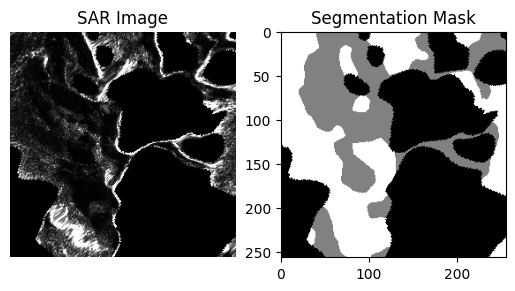

In [6]:
import matplotlib.pyplot as plt
# Display the image and label
image, label = train_dataset_mask[100]
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(0), cmap='gray')  # Remove the channel dimension for display
plt.title("SAR Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(0), cmap='gray')  # Remove the channel dimension for display
plt.title("Segmentation Mask")




### Great. This correctly loads the data as a tensor. now to look into different models!

In [7]:
#import dependencies

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [8]:
#create a segmentation model!

model = smp.Unet(  
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset), # class ids area=0, stone=1, glacier=2, ocean with ice melange=3
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/lib64/python3.9/tarfile.py:2268: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  warnings.warn(


### time to train

In [ ]:
import torch
import matplotlib.pyplot as plt
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset_mask, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    print("Starting training for one epoch...")
 
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, (images, masks) in pbar:
        
        images = images.to(device)  # Shape: [batch_size, 1, height, width]
        masks = masks.to(device).squeeze(1).long()  # Shape: [batch_size, height, width]
        
        optimizer.zero_grad()
        outputs = model(images)
        #print(f"for batch {i}, input shape: {images.shape} outputs shape: {outputs.shape}, masks shape: {masks.shape}")
        loss = criterion(outputs, masks)
        pbar.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    print("Finished training for one epoch.")
  
    return epoch_loss / len(loader)
print("Starting training loop...")

epoch_losses = []  # To store loss values for visualization
for epoch in range(10):
    print(f"Epoch {epoch + 1} starting...")
  
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    epoch_losses.append(train_loss)  # Save loss for visualization
   
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")
print("Training loop completed.")


# Plot the loss values
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()

Starting training loop...
Epoch 1 starting...
Starting training for one epoch...


  0%|          | 15/5843 [02:59<21:58:18, 13.57s/it, loss=1.8] 

# ARCHIVE

In [ ]:
# class GlacierSegDataset(Dataset):
#     """"
   
#     Each SAR image has:
#     - A corresponding segmentation mask (ice vs. background)
#     - A corresponding front mask (glacier front detection)

#     Args:
#         - mode (str): 'train', 'val', or 'test'
#         - parent_dir (str): Root directory containing 'sar_images', 'zones', and 'fronts' folders.
      

#     """

#     def __init__(self, mode, parent_dir, label_type = "mask", original_images_file="/home/users/amorgan/Calving_Fronts_and_Where_to_Find_Them/original_square_images_actual_names.txt"):
#         print(f"Initializing GlacierSegDataset in {mode} mode...")
#         self.label_type = label_type #choose between 'mask' and 'front'

#         self.image_dir = os.path.join(parent_dir, "sar_images", mode)
#         self.mask_dir = os.path.join(parent_dir, "zones", mode)
#         self.front_dir = os.path.join(parent_dir, "fronts", mode)

#          # Read the original images list from the provided file
#         with open(original_images_file, 'r') as f:
#             self.original_images = set(line.strip() for line in f.readlines())  # Keep the full filename with extension

#         # Debug: Print the original image filenames
#         print(f"Original images from {original_images_file}: {list(self.original_images)[:5]}...")

#         # Get the list of images, masks, and fronts in their respective directories
#         all_images = os.listdir(self.image_dir)
#         all_masks = os.listdir(self.mask_dir)
#         all_fronts = os.listdir(self.front_dir)

#         # Debug: Check the available images, masks, and fronts before filtering
#         print(f"All images in {self.image_dir}: {all_images[:5]}...")  # Print first 5 filenames
#         print(f"All masks in {self.mask_dir}: {all_masks[:5]}...")    # Print first 5 filenames
#         print(f"All fronts in {self.front_dir}: {all_fronts[:5]}...")  # Print first 5 filenames

#         # Match images with masks and fronts by their full filename
#         self.images = [
#             f for f in all_images if f in self.original_images  # Directly match the full filename
#         ]
#         # self.images = list(self.original_images)

#         # Debug: Print the matched images
#         print(f"Matched images: {self.images[:5]}...")

#         # Match masks and fronts by the exact same image name but with '_zones' and '_front' suffixes
#         self.masks = sorted([
#             f for f in all_masks if f.replace('_zones', '') in self.images
#         ])
#         self.fronts = sorted([
#             f for f in all_fronts if f.replace('_front', '') in self.images
#         ])

#         # Debug: Print filtered images, masks, and fronts
#         print(f"Filtered images in {self.image_dir}: {self.images[:5]}...")
#         print(f"Filtered masks in {self.mask_dir}: {self.masks[:5]}...")
#         print(f"Filtered fronts in {self.front_dir}: {self.fronts[:5]}...")


#         print(f"Number of images: {len(self.images)}, masks: {len(self.masks)}, fronts: {len(self.fronts)}")
#         assert len(self.images) == len(self.masks) == len(self.fronts), "Mismatch in dataset size!"

#         self.transform = transforms.Compose([
#             transforms.ToTensor(), #converts HxW numpy array to 1xHxW Pytorch tensor
#             transforms.Normalize(mean=0.3047126829624176, std=0.32187142968177795) #mean and sd of the data

#          ])


#     def __len__(self):
#         """"
#         Returns the number of samples in the dataset
#         """
#         return len(self.images)
    
#     def __getitem__(self, idx):
#         """"
#         Loads a SAR image,  and its corresponding label (either mask or front)
#         """

#         image_name = self.images[idx]
#         print(f"Loading image: {image_name}")
#         image = cv2.imread(os.path.join(self.image_dir, image_name), cv2.IMREAD_GRAYSCALE)


#         # Choose label type dynamically
#         if self.label_type == "mask":
#             label_path = os.path.join(self.mask_dir, self.masks[idx])
            
#         elif self.label_type == "front":
#             label_path = os.path.join(self.front_dir, self.fronts[idx])
            
#         else:
#             raise ValueError("Invalid label_type! Choose 'mask' or 'front'.")
        
            
#         label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

#         image = self.transform(image)
#         label = torchvision.transforms.ToTensor()(label)  # No normalization for label
#     # image_path = os.path.join(self.image_dir, self.images[idx])
#         # mask_path = os.path.join(self.mask_dir, self.masks[idx])
#         # front_path = os.path.join(self.front_dir, self.fronts[idx])

#         # image = Image.open(image_path).convert("L")
#         # mask = Image.open(mask_path).convert("L")
#         # front = Image.open(front_path).convert("L")

#         # # Apply transformations
#         # image = self.transform(image)
#         # mask = self.transform(mask)
#         # front = self.transform(front)

#         # print(f"Loading image: {image}, mask: {mask}, front: {front}")

#         # print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Front shape: {front.shape}")

#         # Print tensor shapes after transformation
#         print(f"Transformed image shape: {image.shape}, Transformed label shape: {label.shape}")


#         return image, label # Returns (1, 256, 256) tensors
    
